In [1]:
pip install transformers torch datasets --quiet

In [2]:
# CONFIG
TEXT_MODEL = 'sagorsarker/bangla-bert-base'
EARLY_STOPPING_THRESHOLD = 0.5
EPOCH = 10
BATCH_SIZE = 32
WEIGHT_DECAY = 0.01

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
df = pd.read_csv('/content/train.csv')
tdf = pd.read_csv('/content/test.csv')

In [5]:
# Data Cleaning: Check for missing or invalid values
print("Checking for missing values in training data:")
print(df[['category', 'class']].isna().sum())
print("Checking for missing values in test data:")
print(tdf[['category', 'class']].isna().sum())

Checking for missing values in training data:
category    0
class       0
dtype: int64
Checking for missing values in test data:
category    0
class       0
dtype: int64


In [6]:
df = df[~df['text'].isin(['[NULL]', ''])]
tdf = tdf[~tdf['text'].isin(['[NULL]', ''])]

In [7]:
print(df['category'].value_counts())
print(df['class'].value_counts())
print(tdf['category'].value_counts())
print(tdf['class'].value_counts())

category
Unsafe    529
Safe      376
Name: count, dtype: int64
class
Safe        376
Suicidal    191
Adult       186
Harmful     152
Name: count, dtype: int64
category
Unsafe    130
Safe       99
Name: count, dtype: int64
class
Safe        99
Suicidal    50
Adult       44
Harmful     36
Name: count, dtype: int64


In [8]:
categories = ['Safe', 'Unsafe']
df['category'] = pd.Categorical(df['category'], categories=categories, ordered=True)
df['category'], category_uniques = pd.factorize(df['category'], sort=True)
tdf['category'] = pd.Categorical(tdf['category'], categories=categories, ordered=True)
tdf['category'], tcategory_uniques = pd.factorize(tdf['category'], sort=True)

In [9]:
classes = ['Adult', 'Harmful', 'Suicidal']
unsafe_df = df[df['category'] == 1].copy()  # Filter for Unsafe comments
unsafe_tdf = tdf[tdf['category'] == 1].copy()  # Filter for Unsafe test comments
unsafe_df['class'], class_uniques = pd.factorize(unsafe_df['class'], sort=True)
unsafe_tdf['class'], tclass_uniques = pd.factorize(unsafe_tdf['class'], sort=True)

In [10]:
train_dataset = Dataset.from_pandas(df[['text', 'category']].rename(columns={'category': 'labels'}))
test_dataset = Dataset.from_pandas(tdf[['text', 'category']].rename(columns={'category': 'labels'}))
unsafe_train_dataset = Dataset.from_pandas(unsafe_df[['text', 'class']].rename(columns={'class': 'labels'}))
unsafe_test_dataset = Dataset.from_pandas(unsafe_tdf[['text', 'class']].rename(columns={'class': 'labels'}))

In [11]:
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
binary_model = AutoModelForSequenceClassification.from_pretrained(TEXT_MODEL, num_labels=2)
multiclass_model = AutoModelForSequenceClassification.from_pretrained(TEXT_MODEL, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'class

In [12]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

In [13]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
unsafe_train_dataset = unsafe_train_dataset.map(tokenize_function, batched=True)
unsafe_test_dataset = unsafe_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Map:   0%|          | 0/529 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [14]:
# train_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
# test_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
# unsafe_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
# unsafe_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [16]:
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=EARLY_STOPPING_THRESHOLD
)

In [17]:
binary_training_args = TrainingArguments(
    output_dir='./binary_results',
    num_train_epochs=EPOCH,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./binary_logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [18]:
multiclass_training_args = TrainingArguments(
    output_dir='./multiclass_results',
    num_train_epochs=EPOCH,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./multiclass_logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [19]:
class CustomTrainer(Trainer):
    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval"):
        if dataloader is None or len(dataloader.dataset) == 0:
            print(f"Warning: Evaluation dataset is empty for {description}")
            return EvalLoopOutput(predictions=None, label_ids=None, metrics={}, num_samples=0)
        # Force prediction_loss_only to False to ensure loss is computed
        return super().evaluation_loop(
            dataloader=dataloader,
            description=description,
            prediction_loss_only=False,
            ignore_keys=ignore_keys,
            metric_key_prefix=metric_key_prefix
        )

In [20]:
binary_trainer = CustomTrainer(
    model=binary_model,
    args=binary_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

binary_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: arefinlabibndc19 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.706300,0.638425,0.694323,0.708990,0.694323,0.674430
2,0.586100,0.590985,0.698690,0.710531,0.698690,0.681387
3,0.599600,0.586184,0.716157,0.718346,0.716157,0.708098
4,0.521600,0.591166,0.724891,0.724576,0.724891,0.724720
5,0.408500,0.631035,0.694323,0.697290,0.694323,0.682841
6,0.311200,0.745057,0.659389,0.674638,0.659389,0.629322


TrainOutput(global_step=174, training_loss=0.5381632865160361, metrics={'train_runtime': 858.9685, 'train_samples_per_second': 10.536, 'train_steps_per_second': 0.338, 'total_flos': 1428693030604800.0, 'train_loss': 0.5381632865160361, 'epoch': 6.0})

In [21]:
multiclass_trainer = CustomTrainer(
    model=multiclass_model,
    args=multiclass_training_args,
    train_dataset=unsafe_train_dataset,
    eval_dataset=unsafe_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

multiclass_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.086600,1.030534,0.492308,0.470785,0.492308,0.432897
2,1.008000,0.937948,0.638462,0.610247,0.638462,0.616599
3,0.895600,0.835558,0.638462,0.627674,0.638462,0.624432
4,0.836400,0.730355,0.653846,0.624592,0.653846,0.630182
5,0.689100,0.657245,0.661538,0.666447,0.661538,0.646502
6,0.602400,0.577322,0.692308,0.681243,0.692308,0.674963


TrainOutput(global_step=102, training_loss=0.8522552649180094, metrics={'train_runtime': 784.8699, 'train_samples_per_second': 6.74, 'train_steps_per_second': 0.217, 'total_flos': 835121987868672.0, 'train_loss': 0.8522552649180094, 'epoch': 6.0})

In [22]:
binary_preds = binary_trainer.predict(test_dataset)
binary_labels_pred = np.argmax(binary_preds.predictions, axis=1)

unsafe_test_indices = np.where(binary_labels_pred == 1)[0]
unsafe_texts_predicted = tdf.iloc[unsafe_test_indices]['text'].tolist()

# Create new dataset for unsafe predictions
unsafe_pred_df = pd.DataFrame({'text': unsafe_texts_predicted})
unsafe_pred_dataset = Dataset.from_pandas(unsafe_pred_df)
unsafe_pred_dataset = unsafe_pred_dataset.map(tokenize_function, batched=True)

multiclass_preds = multiclass_trainer.predict(unsafe_pred_dataset)
multiclass_labels_pred = np.argmax(multiclass_preds.predictions, axis=1)

# Map back to class names
unsafe_classes = class_uniques[multiclass_labels_pred]

final_predictions = []
j = 0
for i in range(len(tdf)):
    if binary_labels_pred[i] == 0:
        final_predictions.append('Safe')
    else:
        final_predictions.append(unsafe_classes[j])
        j += 1

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [23]:
true_labels = []
for i, row in tdf.iterrows():
    if row['category'] == 0:
        true_labels.append('Safe')
    else:
        true_labels.append(row['class'])

Classification Report:
              precision    recall  f1-score   support

        Safe       0.49      0.59      0.54        44
       Adult       0.18      0.06      0.09        36
     Harmful       0.68      0.68      0.68        99
    Suicidal       0.69      0.92      0.79        50

    accuracy                           0.62       229
   macro avg       0.51      0.56      0.52       229
weighted avg       0.57      0.62      0.58       229



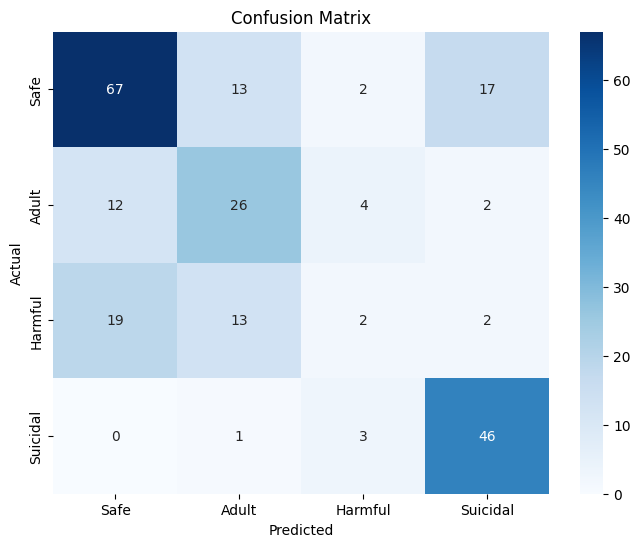

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Report
print("Classification Report:")
print(classification_report(true_labels, final_predictions, target_names=['Safe', 'Adult', 'Harmful', 'Suicidal']))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, final_predictions, labels=['Safe', 'Adult', 'Harmful', 'Suicidal'])

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Adult', 'Harmful', 'Suicidal'],
            yticklabels=['Safe', 'Adult', 'Harmful', 'Suicidal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()